In [1]:
# example string to do mini tests on
example = "I just EASILY had the BEST lunch I've ever eaten!  It was THAT good!\n\nThe chicken tortilla soup was out of this world...light and delicate...fresh and HOT!!!\nI had two fish tacos with no tortilla.  One was a regular fish taco and the other was a beer battered fish taco.l\n\nThe fire roasted salsa was EASILY the best salsa I have ever had, too!\n\nThis place is a serious gem!  I could go there every single day!\n\nThanks guys!!"

# Import Benepar


In [2]:
import benepar
benepar.download("benepar_en2")
parser = benepar.Parser("benepar_en2")

D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

# Import Entity Recognition Model

In [ ]:
import spacy

model_dir = "./models"
nlp = spacy.load(model_dir)s

In [ ]:
def get_entities(nlp_model, text):
    """
    Input nlp_model and text, retrieve a list of unique entities from the text.
    """
    doc = nlp_model(text)
    entities = set()
    for ent in doc.ents:
        if ent.label_ == "PRODUCT":
            entities.add(ent.text)
    return list(entities)

In [ ]:
example_entity_list = get_entities(nlp, example)
example_entity_list

In [7]:
#quick fix
#example_entity_list = ['chicken tortilla soup', 'fish tacos', 'tortilla', 'beer battered fish taco', 'fire roasted salasa', 'place']

In [8]:
example

"I just EASILY had the BEST lunch I've ever eaten!  It was THAT good!\n\nThe chicken tortilla soup was out of this world...light and delicate...fresh and HOT!!!\nI had two fish tacos with no tortilla.  One was a regular fish taco and the other was a beer battered fish taco.l\n\nThe fire roasted salsa was EASILY the best salsa I have ever had, too!\n\nThis place is a serious gem!  I could go there every single day!\n\nThanks guys!!"

# Sentiment Helper Code

In [9]:
import collections
import re

def remove_nestings(lst): 
    output = []
    
    def remove_nestings_recursive(l):
        for i in l: 
            if type(i) == list: 
                remove_nestings_recursive(i) 
            else: 
                output.append(i)
    
    remove_nestings_recursive(lst)
    
    return output

def continue_splitting(review,list_of_dividers):
        
    temp = list_of_dividers.copy()
    l = [review]
    while len(temp) > 0:
        divider = temp.pop(0)
        l_new = []
        for i in l:
            l_new += i.split(divider)
        l = l_new
    return l

def join_clause(review, list_of_split_clauses, list_of_dividers):
    output = []
    loc_of_split_clauses = []
    for clause in list_of_split_clauses:
        loc_of_split_clauses.append(review.find(clause))
    for divider in list_of_dividers:
        print(divider)
        loc_div = review.find(divider)
        print(loc_div)
        for i in range(len(loc_of_split_clauses)):
            if loc_div > loc_of_split_clauses[i]:
                print(loc_div,loc_of_split_clauses[i])
                
def join_partitions(long_review,entity_with_review):
    loclist = []
    for (_, clause) in entity_with_review:
        loclist.append((long_review.find(clause),long_review.find(clause)+len(clause)))
    starts = {i for (i,j) in loclist}
    ends = {j for (i,j) in loclist}
    starts.add(len(long_review))
    newends = {}
    for i in ends:
        newends[i] = min([x for x in starts if x >= i])
    for i in newends:
        pass
    new_entity_with_review = []
    for i in range(len(loclist)):
        tup = loclist[i]
        entity = entity_with_review[i][0]
        st = tup[0]
        en = newends[tup[1]]
        new_entity_with_review.append((entity,long_review[st:en]))
    return new_entity_with_review

def split_long_string(review):
    num = len(review)
    split_list = []
    start = 0
    end = 0
    while num != end:
        if num - end < 1000:
            end = num
            split_list.append(review[start:end])
        else:
            end = review[start:(start+1000)].rfind('.')
            if end == -1:
                end = review[start:(start+1000)].rfind(' ') #if no '.', space will do
                if end == -1:
                    end = min(start + 1000,num)
            split_list.append(review[start:end])
            start = end
    print(start,end)
    return(split_list)

def split_review_naive(review,entities):
    clauses = re.split('[.?!]',review)
    lenlist = [len(x) for x in clauses]
    clauses = [x for _, x in sorted(zip(lenlist,clauses),reverse=False)]
    entity_with_clause = []
    for entity in entities:
        for clause in clauses:
            if entity in clause:
                entity_with_clause.append((entity,clause))
                break
    return(join_partitions(review,entity_with_clause))

def min_tree(review, entities, parser, output = 'minimum'):
    
    #review is string, entities is list of strings, parser is parser object
    # TODO: How well are each review punctuatd and so forth EDA
    if output == 'partition':
        full_review = ''
        
    treelist = []
    lenlist = []
    temp = review.split('\n')
    
    if output == 'no_parse':
        return(split_review_naive(review,entities))
    
    if len(review) > 1000:
        split_reviews = split_long_string(review)
    else:
        split_reviews = [i for i in temp if len(i) > 1 and len(i) <= 1000 ]
    
    for rev in split_reviews:
        if rev and rev.strip():
            u = parser.parse(rev) # tree 

            if type(u) == str:
                u = nltk.Tree.fromstring(u)

            for s in u.subtrees(): # subtrees 
                if s.label() == 'S': # if sentence
                    treelist += [s]
                    lenlist += [len(s.leaves())] # how long clause
                        
            if output == 'partition':
                full_review += ' '.join(u.leaves()) + ' '

    treelist = [x for _, x in sorted(zip(lenlist,treelist),reverse=False)] # sort by lenlisit
    clauses = [' '.join(tree.leaves()) for tree in treelist]
    
    #If there is no sentences detected, then the full review is the only clause.
    if not clauses:
        if output == 'partition':
            clauses.append(full_review)
        else:
            clauses.append(review)
    entity_with_clause = []
    
    if output == 'all':
        for entity in entities:
            clauselist = []
            for clause in clauses:
                if entity in clause:
                    clauselist.append(clause)
            entity_with_clause.append((entity,clauselist))
    
    #TODO: create rules and test them
    elif output == 'minimum':
        for entity in entities:
            for clause in clauses:
                if entity in clause:
                    entity_with_clause.append((entity,clause))
                    break
                    
    elif output == 'partition':
        #first find minimal clause
        for entity in entities:
            for clause in clauses:
                if entity in clause:
                    entity_with_clause.append((entity,clause))
                    break
        #get location of minimal clause in review
        
        entity_with_clause = join_partitions(full_review,entity_with_clause)
    
    return entity_with_clause

# Code to Perform Sentiment Analysis

In [10]:
#STANFORD NLP
import numpy as np
from pycorenlp import StanfordCoreNLP
def stanford_sentiment_start():
    nlp = StanfordCoreNLP('http://localhost:9000')
    return nlp

def stanford_sentiment(entity_with_clause):
    nlp = stanford_sentiment_start()
    entity_with_sentiment = []
    for entity, clause in entity_with_clause:
        result = nlp.annotate(clause,
                   properties={
                       'annotators': 'sentiment',
                       'outputFormat': 'json'
                   })
        sentiment = np.dot(result['sentences'][0]['sentimentDistribution'], [-2, -1, 0, 1, 2])
        entity_with_sentiment.append((entity, sentiment))
    return entity_with_sentiment

#VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def vader_sentiment(entity_with_clause):
    analyzer = SentimentIntensityAnalyzer()
    entity_with_sentiment = []
    for entity, clause in entity_with_clause:
        sentiment = analyzer.polarity_scores(clause)['compound']
        entity_with_sentiment.append((entity,sentiment))
    return(entity_with_sentiment)       

# Run sentiment analysis

In [11]:
def gen_sentiment(review, entities, parser = [], sentiment_package = 'vader', parse_package = 'benepar', rule = 'rule_1'):
    
    #print("\nLoading Parser")
    
    #first is the parser
    if not parser and parse_package == 'benepar':
        parser = benepar.Parser("benepar_en2")
    elif not parser and parse_package == 'stanford':
        #parser = StanfordNLP('http://localhost')
        raise Exception('incorrect parse package')
    elif parser:
        pass
    else:
        raise Exception('incorrect parse package')
    
    #print("Parser =", parse_package)

        
    #second is the rule
    
    #print("\nLoading Rule")
    
    if rule == 'rule_1':
        
        #print("Rule =",rule)
        
        entity_with_review = min_tree(review, entities, parser, output = 'minimum')
        
        #print("\nTree Generated")
        
        entity_with_sentiment = sentiment_analysis(entity_with_review, sentiment_package)
        
        #print("\nSentiment Generated")

        
    elif rule == 'rule_2':
        
        #print("Rule =",rule)
        
        entity_with_review = min_tree(review, entities, parser, output = 'all')
        
        #print("\nTree Generated")
        entity_with_sentiment = []
        sentiment = 0
        for ent, revlist in entity_with_review:
            for clause in revlist:
                sentiment = sentiment_analysis_indiv(clause,sentiment_package)
                if sentiment_package == 'benepar' and abs(sentiment) != 0:
                    break
                elif sentiment_package == 'stanford' and abs(sentiment) > 0.5:
                    break
                    #if sentiment is not neutral, stop. If sentiment is neutral, keep going up tree.
            entity_with_sentiment.append((ent,sentiment))
        #print("\nSentiment Generated")        
        
    elif rule == 'rule_3':
        
        #print("Rule =",rule)
        
        entity_with_review = min_tree(review, entities, parser, output = 'all')
        
        #print("\nTree Generated")
        
        entity_with_sentiment = []
        for ent, revlist in entity_with_review:
            sentiment_list = []
            for clause in revlist:
                sentiment = sentiment_analysis_indiv(clause,sentiment_package)
                sentiment_list.append(sentiment)
            entity_with_sentiment.append((ent,np.mean(sentiment_list)))
            
        #print("\nSentiment Generated") 
        
    elif rule == 'rule_4':
        
        #print("Rule =",rule)
        
        entity_with_review = min_tree(review, entities, parser, output = 'partition')
        #print("\nTree Generated")
        
        entity_with_sentiment = sentiment_analysis(entity_with_review, sentiment_package)
        
        #print("\nSentiment Generated")
        
    elif rule == 'rule_5':
        
        #print("Rule =",rule)
        
        entity_with_review = min_tree(review, entities, parser, output = 'minimum')
        entity_with_review_p = min_tree(review, entities, parser, output = 'partition')
        #print("\nTree Generated")
        
        entity_with_sentiment = sentiment_analysis(entity_with_review, sentiment_package)
        for i in range(len(entity_with_sentiment)):
            sent = entity_with_sentiment[i][1]
            if sentiment_package == 'vader' and sent != 0:
                entity_with_sentiment[i] = (entity_with_sentiment[i][0],sentiment_analysis_indiv(entity_with_review_p[i][1],sentiment_package))
            elif sentiment_package == 'stanford' and abs(sent) > 0.5:
                entity_with_sentiment[i] = (entity_with_sentiment[i][0],sentiment_analysis_indiv(entity_with_review_p[i][1],sentiment_package))
    
    elif rule == 'rule_6':
        
        entity_with_review = min_tree(review, entities, parser, output = 'no_parse')
        entity_with_sentiment = sentiment_analysis(entity_with_review, sentiment_package)
        
        #print("\nSentiment Generated")
    
    else:
        raise Exception('incorrect rule')
    
    return(entity_with_sentiment)
    
def sentiment_analysis(entity_with_review, sentiment_package = 'stanford'):
    #takes in list of tuples
    if sentiment_package == 'stanford':
        return stanford_sentiment(entity_with_review)
    elif sentiment_package == 'vader':
        return vader_sentiment(entity_with_review)
    else:
        raise Exception('incorrect sentiment package')

def sentiment_analysis_indiv(clause,sentiment_package = 'stanford'):
    #takes in a single review
    if sentiment_package == 'stanford':
        nlp = stanford_sentiment_start()
        result = nlp.annotate(clause,
                   properties={
                       'annotators': 'sentiment',
                       'outputFormat': 'json'
                   })
        print(result['sentences'][0]['sentimentDistribution'])
        return np.dot(result['sentences'][0]['sentimentDistribution'], [-2, -1, 0, 1, 2])
    elif sentiment_package == 'vader':
        analyzer = SentimentIntensityAnalyzer()
        return analyzer.polarity_scores(clause)['compound']
    else:
        raise Exception('incorrect sentiment package')

# Perform End-to-End Validation

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from tqdm.notebook import tqdm
from collections import defaultdict

In [13]:
# GET ALL RESTAURANTS 

# import data
df_raw = pd.read_json("restaurant_reviews_1900k.json", lines=True)

# only get restaurants with many reviews
many_reviews = df_raw[['business_id','review_id']].groupby("business_id")['review_id'].nunique()
many_reviews = many_reviews[many_reviews > 1000].index # more than 100 reviews
df = df_raw[df_raw.business_id.isin(set(many_reviews))]
print("Number of businesses in subset: ", len(df.business_id.unique()))

# only grab restaurants with 3-4 stars
business_stars = df[['business_id', 'stars']].groupby('business_id').mean()
business_ids_similar_stars= business_stars[
    (business_stars.stars >= 3.0) 
    & (business_stars.stars <= 4.0)].index

print("Number of businesses with 3.5-4.5 stars: ", len(business_ids_similar_stars.unique()))

Number of businesses in subset:  142
Number of businesses with 3.5-4.5 stars:  57


In [14]:
bus = df[df.business_id.isin(set(business_ids_similar_stars[:50]))]

In [16]:
bus.to_csv("restaurants_with_enough_stars_50.csv")

In [17]:
business_ids_similar_stars = bus.business_id.unique()

In [20]:
from scipy.stats import spearmanr
rules = ['rule_1', 'rule_2', 'rule_3', 'rule_4', 'rule_5', 'rule_6']

rule = 'rule_2'

correlation_scores = []

print("RULE: ", rule)
for bus_id in tqdm(business_ids_similar_stars):
    print("Running on restaurant ", bus_id, "...")
    subset = bus[bus.business_id == bus_id]
    
    # only get reviews with enough amount of text
    reviews_subset = [review for review in subset.text if len(review) < 400]

    print("Number of Reviews left after subset length: ", len(reviews_subset))
    
    # get set of entities for this particular restaurant,
    # and count how many reviews each entity have
    entities_with_count = defaultdict(int) 
    review_entities = [] # extract entities for each review
    print("Extracting entities from each review...")
    for review in tqdm(reviews_subset):
        entities = get_entities(nlp, review)

        # add this review as a count to an entity
        for ent in entities:
            entities_with_count[ent.lower()] += 1

        review_entities.append(entities)
        
    # only grab entities that have enough reviews
    print("Filtering entities to have enough reviews...")
    entities_with_enough_reviews = []
    threshold = 30
    for key, value in entities_with_count.items():
        if value >= threshold:
            entities_with_enough_reviews.append(key)
            
    # TRUE RANKINGS CALCULATION
    # for each entity, average ratings
    true_rankings = defaultdict(list)

    print("Calculating Yelp Star Rankings... ")
    for entity in entities_with_enough_reviews:
        true_rankings['entity'] += [entity]
        entity_reviews = subset[subset.text.str.contains(entity, case=False)]
        true_rankings['average_stars'] += [np.mean(entity_reviews.stars)]

    true_rankings = pd.DataFrame(true_rankings)
    
    # PREDICTION RANKING CALCULATION
    print("Calculating Prediction Rankings...")
    # Filter entities of each review to be from the entities_with_enough_review set
    entity_filter = set(entities_with_enough_reviews)

    filtered_entities = []

    for entities in review_entities:
        filtered = []
        for ent in entities:
            ent = ent.lower()
            if ent in entity_filter:
                filtered.append(ent)
        filtered_entities.append(filtered)
    
#     # run validation for each rule
#     for rule in rules:

    # perform sentiment analysis for each review with filtered entities above
    predicted_scores = defaultdict(list)

    print("Performing sentiment analysis for each review... ")
    for i, review in enumerate(tqdm(reviews_subset)):
        entities = filtered_entities[i]

    #     print(review)

        scores = gen_sentiment(review, entities, parser = parser, sentiment_package='vader', rule=rule)

        # save results 
        for entity, score in scores:
            predicted_scores[entity] += [score]

    # create rankings from scores
    predicted_rankings = defaultdict(list)
    for entity, scores in predicted_scores.items():
        predicted_rankings['entity'] += [entity]
        predicted_rankings['predicted_score'] += [np.mean(scores)]

    predicted_rankings = pd.DataFrame(predicted_rankings)

    #### may not be necessary to do these castings
    predicted_rankings['entity'] = predicted_rankings['entity'].astype(str)
    true_rankings['entity'] = true_rankings['entity'].astype(str)
    ####
    
    full_rankings = true_rankings.merge(predicted_rankings, how='left').fillna(0)

    # spearman correlation metric
    print("Rankings result: ")
    print(full_rankings)
    
    corr, pvalue = spearmanr(full_rankings.average_stars, full_rankings.predicted_score)
    print("Spearman Correlation Score: ", corr)
    correlation_scores.append(corr)
        #     print(gen_sentiment(review, entities, parser = parser,sentiment_package='vader'))

RULE:  rule_2


Running on restaurant  d_L-rfS1vT3JMzgCUGtiow ...
Number of Reviews left after subset length:  679
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0         fish       3.533333         0.467778
1        staff       4.046512         0.633719
2         food       3.826979         0.562120
3      service       3.904552         0.566233
4      chicken       3.864151         0.692516
5         corn       3.955285         0.741853
6   atmosphere       4.108696         0.647784
7         menu       4.064815         0.680333
8    margarita       3.813559         0.654366
9         meal       3.812081         0.617319
10       steak       4.108844         0.653063
11   guacamole       3.842105         0.694223
12       place       3.782772         0.599642
13       lunch       4.032864         0.622830
14       salsa       3.706849         0.695825
15      dinner       3.873874         0.687476
16     special       3.912698         0.727147
Spearman Correlation Score:  0.22058823529411767
Running on restaurant  N0apJkxIem2E8irTBRKnHw ...
Number of Reviews left after subset 


Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
         entity  average_stars  predicted_score
0       service       3.959103         0.578228
1          food       3.888521         0.552700
2         place       3.937050         0.634821
3          menu       4.026415         0.679868
4        dinner       4.055351         0.702276
5          crab       3.886957         0.516650
6         price       3.785530         0.603861
7         pizza       3.904573         0.580403
8         staff       4.228571         0.693377
9         pasta       3.835979         0.592154
10          bit       3.762411         0.647967
11        lunch       3.994709         0.678735
12       burger       3.974747         0.645167
13       potato       4.054902         0.655875
14  blue cheese       4.013333         0.663441
15   atmosphere       4.061856         0.478476
16       prices       3.939850         0.584797
17         meal       3.955556         0.637195
18      chicken       3.959375         0.628001
19        bread      


Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0      service       3.901774         0.601628
1       cheese       3.900000         0.762764
2        place       3.953243         0.743835
3        table       3.638191         0.707831
4        bread       3.953416         0.661675
5         food       3.883984         0.622737
6         menu       3.869658         0.618816
7      dessert       3.984375         0.652098
8     sandwich       3.978541         0.645788
9        lunch       3.954064         0.685100
10  atmosphere       4.210084         0.626412
11     chicken       3.908072         0.683115
12       pizza       3.857143         0.734281
13       staff       4.008584         0.747724
14        meal       3.700389         0.683798
15       salad       3.972067         0.753769
16      dinner       3.978056         0.771343
Spearman Correlation Score:  0.06862745098039216
Running on restaurant  ujHiaprwCQ5ewziu0Vi9rw ...
Number of Reviews left after subset 


Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
       entity  average_stars  predicted_score
0        meat       3.432749         0.372643
1     dessert       3.586803         0.455950
2       steak       3.537764         0.515530
3      dinner       3.526952         0.393924
4       sushi       3.466799         0.468228
5        crab       3.396911         0.367581
6      buffet       3.399582         0.417000
7       price       3.330591         0.419884
8   breakfast       3.678261         0.534913
9        food       3.294837         0.384290
10      place       3.265097         0.357977
11      taste       2.984314         0.345219
12    service       3.393973         0.427818
13        rib       3.322917         0.461583
14     coffee       3.323864         0.489191
15       beef       3.603960         0.387062
16    seafood       3.586146         0.468716
17       lamb       3.755102         0.444968
18       fish       3.304348         0.360169
19        bit       3.510909         0.527990
20      staff  


Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
       entity  average_stars  predicted_score
0      buffet       3.224237         0.412168
1         rib       3.005277         0.447278
2       sushi       3.274368         0.378036
3        crab       3.254795         0.400640
4     service       3.179104         0.495357
5        food       3.134766         0.427099
6       place       3.154519         0.460699
7       price       3.275229         0.494116
8       lunch       3.331633         0.439430
9   breakfast       3.357759         0.477995
10     dinner       3.231343         0.480467
11       wine       3.415301         0.534457
12       beer       3.394886         0.470424
13    dessert       3.211137         0.449806
14      staff       3.299213         0.530106
Spearman Correlation Score:  0.3571428571428571
Running on restaurant  HhVmDybpU7L50Kb5A0jXTg ...
Number of Reviews left after subset length:  1600
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0    appetizer       3.367589         0.509477
1        bacon       3.631478         0.536297
2        fries       3.464529         0.590646
3       burger       3.547432         0.613730
4        place       3.325500         0.495848
5      service       3.419381         0.447595
6       prices       3.549383         0.504995
7         food       3.323452         0.477334
8        table       2.919732         0.286647
9         menu       3.347826         0.460614
10      cheese       3.564815         0.587585
11       staff       3.508065         0.615649
12     special       3.163934         0.379407
13         bit       3.387805         0.689771
14        meat       2.943231         0.332509
15        meal       3.326829         0.495678
16        beer       3.432292         0.570860
17       sauce       3.374723         0.408923
18   breakfast       3.484962         0.533057
19      dinner       3.458537         0.5


Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0        place       4.010620         0.598513
1      service       3.852230         0.570630
2         food       3.917914         0.561857
3   atmosphere       4.151436         0.628483
4    breakfast       4.143617         0.602430
5          bit       3.694704         0.593442
6        split       4.145985         0.607717
7         meal       3.967667         0.629794
8        price       3.952672         0.657327
9       prices       4.032143         0.528145
10        eggs       3.970721         0.676019
11       steak       3.882143         0.648489
12        menu       4.066667         0.551851
13     portion       4.178002         0.617227
14     chicken       3.869048         0.635675
15       staff       4.138554         0.688039
16       taste       3.431159         0.653367
17    cocktail       4.091988         0.546540
18      omelet       4.050398         0.584161
19      coffee       3.776190         0.5


Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
    entity  average_stars  predicted_score
0    price       3.900542         0.409660
1     food       4.048000         0.612592
2    staff       3.993600         0.622479
3  service       3.663208         0.403768
4    place       3.962097         0.603129
5      bit       3.831522         0.442616
6  gondola       4.423077         0.624935
Spearman Correlation Score:  0.9285714285714288
Running on restaurant  thLX_k20SPJ0KyusGTBIHw ...
Number of Reviews left after subset length:  615
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0        place       3.977427         0.683997
1        staff       4.101010         0.675380
2      service       3.701422         0.524863
3         food       3.838710         0.602496
4       sprout       4.153846         0.756607
5   atmosphere       4.253333         0.625854
6      chicken       4.094595         0.684817
7      coconut       4.314607         0.715271
8         taco       4.094270         0.594366
9         corn       4.092437         0.694728
10        menu       4.036765         0.784167
11       steak       4.155963         0.572323
12   guacamole       4.164557         0.701639
13       lunch       3.927711         0.662542
14   margarita       4.179039         0.556529
15       salsa       3.891720         0.733379
16       green       4.250000         0.649883
Spearman Correlation Score:  0.03921568627450981
Running on restaurant  uuGL8diLlHfeUeFuod3F-w ...
Number of Reviews left after subset 


Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0      service       3.497347         0.405825
1        steak       3.584615         0.539988
2         food       3.557978         0.494794
3         meal       3.574257         0.708223
4    breakfast       3.818841         0.620011
5         beer       3.692308         0.613058
6   atmosphere       4.320000         0.583565
7     sandwich       3.682759         0.661073
8        staff       3.900000         0.778225
9        place       3.569536         0.538981
10        menu       3.626113         0.579674
11       fries       3.637209         0.688911
12      burger       3.587065         0.582888
13       bacon       3.675214         0.474486
14        eggs       3.338710         0.617955
15       lunch       3.650000         0.757042
16     lobster       4.033333         0.619139
17      cheese       3.625000         0.522139
18     chicken       3.752688         0.601963
19      dinner       3.874074         0.6


Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
       entity  average_stars  predicted_score
0       lunch       4.163522         0.693967
1       place       3.953668         0.590055
2        food       3.737527         0.513489
3       staff       3.639640         0.673472
4   breakfast       4.187919         0.633165
5    sandwich       3.850365         0.477500
6      cheese       4.138710         0.597128
7       bagel       4.070822         0.671041
8        soup       4.144385         0.688893
9     service       3.675900         0.471231
10      cream       4.150000         0.624886
Spearman Correlation Score:  0.5090909090909091
Running on restaurant  _j2EtQtgLuXGRBfbM5YwZA ...
Number of Reviews left after subset length:  522
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
     entity  average_stars  predicted_score
0      beef       3.577215         0.476348
1      rice       3.418440         0.464285
2      soup       3.571970         0.491694
3    noodle       3.522572         0.450246
4   service       3.111111         0.293843
5     taste       3.010256         0.364928
6      pork       3.506024         0.323164
7     place       3.385230         0.471569
8      food       3.297222         0.357947
9     price       3.406915         0.450993
10  chicken       3.149425         0.367736
11     duck       3.537736         0.407471
12   prices       3.415929         0.421200
Spearman Correlation Score:  0.6043956043956044
Running on restaurant  TCoBE_BkDRrK0bWrh5VueQ ...
Number of Reviews left after subset length:  644
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
       entity  average_stars  predicted_score
0       staff       3.943396         0.527187
1        food       3.726048         0.501938
2       place       3.892913         0.635896
3        taco       3.993541         0.538303
4        corn       4.123188         0.610894
5  atmosphere       4.296296         0.654280
6        beer       4.215686         0.668109
7       salsa       3.963696         0.615722
8     service       3.450216         0.561966
9        meat       3.811321         0.350400
Spearman Correlation Score:  0.6606060606060605
Running on restaurant  n8Zqqhff-2cxzWt_nwhU2Q ...
Number of Reviews left after subset length:  619
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
         entity  average_stars  predicted_score
0   cauliflower       4.105528         0.780275
1       service       3.612245         0.515730
2         place       3.649695         0.608642
3          menu       3.789174         0.679038
4         staff       3.615942         0.639931
5    atmosphere       4.036458         0.625811
6          beer       3.953368         0.633033
7          food       3.659751         0.567364
8       chicken       3.938889         0.754408
9        burger       3.771144         0.842302
10       cheese       3.917582         0.668717
11        pizza       3.786207         0.552206
12        salad       3.863946         0.837088
13      buffalo       4.123188         0.771054
Spearman Correlation Score:  0.4769230769230769
Running on restaurant  gx2yPrOJSwF1ApJYdGBWIw ...
Number of Reviews left after subset length:  786
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0        staff       4.118012         0.715561
1        place       4.036709         0.685156
2        broth       3.956416         0.664862
3          bun       4.161137         0.631682
4      service       3.837209         0.543923
5         food       3.792722         0.543837
6        table       3.663636         0.517956
7        taste       3.697095         0.589877
8   atmosphere       4.373913         0.707000
9      chicken       4.106818         0.618984
10       lunch       4.260417         0.677384
11        pork       4.193750         0.691686
12      garlic       4.168539         0.834522
13        soup       3.880952         0.654093
14        menu       4.052419         0.689824
Spearman Correlation Score:  0.7714285714285712
Running on restaurant  YPavuOh2XsnRbLfl0DH2lQ ...
Number of Reviews left after subset length:  917
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0        grits       4.315534         0.566869
1      chicken       4.035266         0.631664
2         food       3.775000         0.494032
3      service       3.640625         0.450563
4       cheese       4.184211         0.652937
5        staff       3.924901         0.579029
6        place       3.981037         0.571775
7       waffle       4.070255         0.546594
8   atmosphere       4.193103         0.670682
9      catfish       3.867925         0.514852
10       lunch       3.656934         0.707656
11        side       3.951168         0.528735
12       sweet       4.262500         0.798169
13         bit       3.942222         0.647559
14   soul food       4.013158         0.645838
15        meal       3.666667         0.410463
16      greens       4.148936         0.638841
17         tea       4.045802         0.766170
18        menu       3.975124         0.745159
Spearman Correlation Score:  0.4842105263


Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
     entity  average_stars  predicted_score
0     sushi       3.883817         0.535358
1     place       3.776492         0.539484
2      food       3.488473         0.462014
3      fish       3.872302         0.533455
4      menu       4.107981         0.685692
5     lunch       3.839286         0.472768
6    dinner       3.949008         0.507178
7   dessert       4.235751         0.618517
8   service       3.457729         0.374275
9      tuna       3.990476         0.627502
10     rice       3.760766         0.442118
11    table       3.302703         0.407368
12    price       3.815331         0.435960
13     roll       4.020962         0.629870
14    staff       3.634286         0.607153
15   salmon       4.097792         0.534047
Spearman Correlation Score:  0.7411764705882353
Running on restaurant  K7lWdNUhCbcnEvI0NhGewg ...
Number of Reviews left after subset length:  2374
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
         entity  average_stars  predicted_score
0        buffet       3.753992         0.461455
1          food       3.619450         0.485361
2         staff       3.654102         0.551928
3     breakfast       3.989410         0.509156
4         bacon       3.928571         0.621727
5        cheese       3.770804         0.499978
6    atmosphere       4.058296         0.656338
7       dessert       3.794711         0.516806
8         place       3.606145         0.474907
9           bit       3.754016         0.499751
10        table       3.522546         0.286693
11        sushi       3.441718         0.299952
12         crab       3.421667         0.358369
13      seafood       3.486284         0.296147
14        lunch       3.747759         0.398669
15       salmon       3.644737         0.271991
16      service       3.623086         0.475202
17      special       3.642190         0.251738
18        water       3.601905         0.488119
19        price      


Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
         entity  average_stars  predicted_score
0       service       3.837456         0.595193
1         lunch       3.862500         0.761517
2         place       3.792308         0.677062
3          menu       3.843658         0.686133
4          food       3.814852         0.631337
5    atmosphere       4.093960         0.612719
6     breakfast       3.897143         0.634641
7          meal       3.653543         0.698920
8         grits       4.075269         0.717073
9         green       3.920930         0.776012
10          jam       4.071111         0.734742
11       dinner       3.874214         0.708107
12  goat cheese       4.153846         0.779950
13      chicken       4.059278         0.728455
14        staff       3.963351         0.717052
15       cheese       3.939394         0.648613
Spearman Correlation Score:  0.4088235294117647
Running on restaurant  rTS8LsUmNIiXsXydE49tPA ...
Number of Reviews left after subset length:  721
Extracting entitie


Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0    breakfast       3.227848         0.537446
1         food       3.351942         0.491915
2        table       3.014652         0.301030
3        place       3.390909         0.515229
4       burger       3.447368         0.622887
5      service       3.231481         0.374705
6      chicken       3.384615         0.560448
7         fish       3.504065         0.596146
8        staff       3.514925         0.565102
9   atmosphere       3.735294         0.506821
10   margarita       3.527704         0.612186
11       lunch       3.500000         0.497410
Spearman Correlation Score:  0.5524475524475525
Running on restaurant  YuiM5VKscO8rS1EX7f19_g ...
Number of Reviews left after subset length:  343
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
    entity  average_stars  predicted_score
0    lunch       3.370968         0.645144
1  service       3.730469         0.437822
2     food       3.676516         0.522756
3    place       3.772080         0.555364
4     wine       3.931707         0.495791
5     meal       3.956522         0.560506
6     menu       3.927136         0.619370
7   dinner       3.928030         0.672235
Spearman Correlation Score:  0.04761904761904763
Running on restaurant  T2tEMLpTeSMxLKpxwFdS3g ...
Number of Reviews left after subset length:  588
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0         corn       3.662222         0.633669
1        place       3.750495         0.630810
2        salsa       3.715596         0.660751
3      service       3.756598         0.585074
4         food       3.646953         0.613297
5         taco       3.943246         0.679727
6         fish       3.828343         0.670902
7   atmosphere       4.163636         0.714106
8        salad       4.129252         0.652526
9      avocado       4.176991         0.759750
10       pasta       4.288889         0.694161
11        beer       3.867403         0.617862
12        menu       3.904762         0.733547
13        meal       3.692913         0.442879
14       lunch       4.027778         0.657312
15       staff       4.069307         0.662366
16         dip       3.833333         0.605894
17        tuna       3.977143         0.696182
Spearman Correlation Score:  0.6800825593395253
Running on restaurant  pyqnGlIfP9Zw8LLxB


Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
    entity  average_stars  predicted_score
0     meal       3.881890         0.676382
1  service       3.890792         0.522706
2     food       3.823529         0.575301
3  sashimi       4.078189         0.637450
4    place       3.909091         0.586495
5     menu       4.034810         0.691417
6   dinner       3.786047         0.631053
7    sushi       3.769585         0.530429
Spearman Correlation Score:  0.4761904761904762
Running on restaurant  lKom12WnYEjH5FFemK3M1Q ...
Number of Reviews left after subset length:  579
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0     sandwich       3.539683         0.492331
1        place       3.372881         0.457317
2         slaw       3.427586         0.691601
3        fries       3.367052         0.553691
4     pastrami       3.716495         0.577925
5         food       3.356250         0.386270
6         meat       3.224490         0.482484
7         cole       3.420290         0.674111
8      service       3.468504         0.436141
9     coleslaw       3.330769         0.498071
10       bread       3.252174         0.437458
11      cheese       3.576316         0.486610
12  atmosphere       3.852273         0.573482
Spearman Correlation Score:  0.41208791208791207
Running on restaurant  VR8QvH2g-jEG5EfMzA_G9w ...
Number of Reviews left after subset length:  577
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0      service       3.682540         0.481683
1       cheese       4.014778         0.527874
2         beer       3.957516         0.558835
3   atmosphere       4.033149         0.689691
4         food       3.825127         0.530793
5        place       3.836327         0.582914
6          pie       3.880546         0.588209
7         fish       3.637427         0.563206
8        table       3.468182         0.465907
9        staff       3.787234         0.527981
10      dinner       3.689873         0.516797
Spearman Correlation Score:  0.6090909090909091
Running on restaurant  NvKNe9DnQavC9GstglcBJQ ...
Number of Reviews left after subset length:  1225
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0        place       3.928571         0.615254
1      service       3.862745         0.565537
2         menu       3.970660         0.587943
3         food       3.881324         0.555954
4      chicken       4.059126         0.684601
5        salad       3.941909         0.698593
6         side       3.909449         0.644573
7      special       3.844765         0.378616
8    breakfast       3.954622         0.580373
9        lunch       4.013123         0.676861
10       table       3.505000         0.496955
11      burger       4.024316         0.632600
12        eggs       3.683962         0.517117
13       pasta       4.012376         0.594316
14      dinner       4.056022         0.625031
15      buffet       3.924901         0.597595
16       bread       3.858209         0.620260
17      coffee       3.722689         0.527387
18      prices       4.046667         0.604869
19       staff       3.903061         0.7


Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
     entity  average_stars  predicted_score
0      roll       3.988335         0.664367
1      food       3.839041         0.522043
2     place       3.977138         0.594657
3     sushi       4.032134         0.567511
4     price       4.138462         0.628219
5      fish       3.644860         0.529915
6   service       3.852420         0.539563
7     staff       4.153509         0.644590
8      rice       3.834813         0.289182
9     taste       3.210526         0.463059
10    salad       4.190355         0.574000
11  seafood       4.245902         0.543991
12    table       3.669091         0.626010
13     menu       4.056818         0.695719
14   dinner       4.021552         0.623013
15   prices       4.076923         0.646677
16    lunch       3.854701         0.523400
Spearman Correlation Score:  0.5637254901960785
Running on restaurant  QJR4qBUHegWEozSQrGmBPw ...
Number of Reviews left after subset length:  678
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0         food       3.785784         0.532738
1      service       3.839332         0.497071
2   atmosphere       3.985401         0.389217
3         meal       3.812950         0.671787
4        water       3.936909         0.584311
5        olive       3.900000         0.626719
6       dinner       3.903803         0.662204
7        table       3.702128         0.610640
8         wine       3.787500         0.651261
9        place       3.759058         0.558255
10        menu       3.830769         0.658541
11       steak       3.735632         0.583924
12       bread       3.920873         0.605457
13        beef       4.092150         0.659822
14       pasta       3.824786         0.563465
15       salad       3.673913         0.534600
16       lunch       3.983278         0.630210
17   flatbread       4.047458         0.608535
18       staff       3.842932         0.699782
Spearman Correlation Score:  0.2175438596


Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0        place       3.443425         0.607273
1      service       3.635277         0.502816
2         food       3.618469         0.542718
3      chicken       3.767442         0.549067
4   atmosphere       3.867470         0.608089
5        table       3.272537         0.394310
6     meatball       4.069892         0.697171
7        staff       3.505000         0.680740
8         meal       3.575472         0.674929
9        bread       3.863636         0.604554
10      dinner       3.588384         0.670825
11       pasta       3.502674         0.615988
Spearman Correlation Score:  0.15384615384615385
Running on restaurant  JpgVl3d20CMRNjf1DVnzGA ...
Number of Reviews left after subset length:  1176
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0         meat       2.980757         0.400917
1   atmosphere       3.489796         0.586431
2      service       2.959016         0.409081
3        taste       2.489796         0.324600
4    pineapple       3.204167         0.546572
5        place       2.851554         0.424772
6         food       3.133382         0.503953
7        salad       3.066800         0.478079
8         side       2.918630         0.535117
9      special       3.137931         0.628097
10      dinner       2.933806         0.485744
11         bit       3.187879         0.492291
12     sirloin       3.239819         0.624019
13       lunch       3.175862         0.616980
14        meal       2.634078         0.507670
15     seafood       2.943820         0.500160
16       price       2.678967         0.287611
17       steak       2.783730         0.538433
18      salmon       2.928571         0.526068
19     chicken       3.126100         0.7


Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
    entity  average_stars  predicted_score
0    place       3.704385         0.506255
1    staff       3.606061         0.615562
2  service       3.225673         0.367727
3     food       3.719439         0.549610
4   buffet       3.861842         0.592187
Spearman Correlation Score:  0.39999999999999997
Running on restaurant  A5Rkh7UymKm0_Rxm9K2PJw ...
Number of Reviews left after subset length:  621
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0      service       3.900840         0.519046
1         food       3.861080         0.593671
2        place       3.920000         0.630677
3         beer       4.031949         0.629658
4         menu       4.080925         0.604322
5        fries       3.879781         0.731371
6        salad       3.892405         0.708995
7      chicken       3.968051         0.631877
8        lunch       3.845528         0.641921
9        staff       3.906667         0.741496
10  atmosphere       4.266667         0.644258
11      cheese       3.991111         0.642774
12      prices       4.009615         0.631159
13      burger       3.905263         0.763466
Spearman Correlation Score:  -0.12967032967032965
Running on restaurant  LNGBEEelQx4zbfWnlc66cw ...
Number of Reviews left after subset length:  779
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
     entity  average_stars  predicted_score
0     staff       3.864706         0.569582
1   dessert       4.181991         0.619269
2   service       3.800459         0.558232
3      food       3.993949         0.571963
4     price       4.006046         0.532721
5     taste       3.678474         0.507953
6    buffet       4.066116         0.560704
7      crab       4.037209         0.563839
8      wine       4.261815         0.616049
9      beer       4.279539         0.576148
10  seafood       4.035019         0.453849
11    lunch       4.132743         0.473602
12  alcohol       4.075949         0.598570
13    place       3.937151         0.473120
14      bit       4.058824         0.539921
15      rib       3.895503         0.525092
16   dinner       3.961290         0.500909
Spearman Correlation Score:  0.49019607843137264
Running on restaurant  cJWbbvGmyhFiBpG_5hf5LA ...
Number of Reviews left after subset length:  692
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
       entity  average_stars  predicted_score
0       place       3.752404         0.584618
1        beer       3.792453         0.581489
2        food       3.764706         0.600393
3       staff       3.746269         0.673194
4     service       3.605769         0.561519
5  atmosphere       3.908616         0.594271
6     pretzel       3.808901         0.642335
7      dinner       3.532609         0.503882
8     sausage       3.684543         0.556649
Spearman Correlation Score:  0.6166666666666666
Running on restaurant  P7pxQFqr7yBKMMI2J51udw ...
Number of Reviews left after subset length:  1301
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
          entity  average_stars  predicted_score
0        service       3.780053         0.478869
1     atmosphere       4.146617         0.702974
2          place       3.809419         0.617930
3           food       3.713255         0.504971
4           beef       4.005682         0.583018
5           meal       3.717439         0.634922
6         burger       3.929285         0.646452
7          shake       4.044359         0.600829
8          price       3.708397         0.520892
9           beer       3.955000         0.582113
10       special       3.666667         0.557919
11         fries       3.836149         0.580285
12           bit       3.878992         0.588806
13         joint       3.809756         0.660803
14        dinner       3.926641         0.545762
15         cream       4.135211         0.510770
16         steak       3.920489         0.708718
17       lobster       3.906355         0.592213
18          menu       3.850000         0.606641
1


Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0        table       3.522459         0.450574
1        place       3.746732         0.650974
2         food       3.818670         0.601788
3      service       3.827941         0.592246
4   atmosphere       4.006390         0.611217
5        steak       3.822126         0.598553
6        bread       3.977695         0.718417
7      truffle       4.034783         0.684074
8       dinner       3.783964         0.675953
9        staff       4.023392         0.672274
10      cheese       4.027778         0.754769
11        meal       3.777003         0.652854
12        side       3.817699         0.597659
Spearman Correlation Score:  0.532967032967033
Running on restaurant  Y-S2LhHefBdnX8VP5Bh_JA ...
Number of Reviews left after subset length:  556
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
       entity  average_stars  predicted_score
0        food       3.091068         0.342047
1       staff       3.174757         0.461078
2     chicken       3.269231         0.441958
3       salad       3.137931         0.509682
4   breakfast       3.330049         0.467012
5       fries       3.126126         0.559647
6    sandwich       3.168421         0.360121
7       place       3.189415         0.381437
8     service       3.089655         0.319040
9      burger       3.019048         0.379191
10       menu       3.171053         0.594539
11     prices       3.469697         0.397155
Spearman Correlation Score:  0.35664335664335667
Running on restaurant  f4x1YBxkLrZg652xt2KR5g ...
Number of Reviews left after subset length:  2734
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
         entity  average_stars  predicted_score
0          feed       4.118812         0.588665
1          menu       3.939198         0.622873
2         place       3.933333         0.611833
3         plate       3.862235         0.634015
4          hash       3.860392         0.625041
5       pancake       4.085714         0.662259
6       chicken       3.967115         0.629198
7         bacon       3.984942         0.618899
8          food       3.837684         0.555418
9        dinner       4.071672         0.557035
10      service       3.814003         0.548718
11      serving       4.020161         0.641174
12    breakfast       4.061592         0.577813
13         side       3.851584         0.661958
14         meal       3.887442         0.614906
15        gravy       3.784314         0.677255
16         eggs       3.801811         0.558830
17        table       3.507042         0.443596
18       banana       4.284790         0.725968
19  brown sugar      


Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
       entity  average_stars  predicted_score
0        food       3.597920         0.546582
1     service       3.476190         0.453859
2       staff       3.848684         0.572006
3      burger       3.572650         0.487038
4       place       3.607407         0.567555
5  atmosphere       3.955224         0.664578
6     chicken       3.903475         0.644665
7        menu       3.811966         0.607624
8        beer       3.742138         0.540721
Spearman Correlation Score:  0.9333333333333332
Running on restaurant  K0j_Znzin0jShXVnpvW86A ...
Number of Reviews left after subset length:  448
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
       entity  average_stars  predicted_score
0        food       3.583554         0.501829
1     service       3.668016         0.468761
2       place       3.565996         0.549341
3        menu       3.848901         0.564865
4      dinner       3.599034         0.462697
5        dish       3.713080         0.637103
6      paella       3.689218         0.536497
7  atmosphere       3.993197         0.695706
Spearman Correlation Score:  0.6666666666666669
Running on restaurant  BjH8Xepc10i6OhCDQdX6og ...
Number of Reviews left after subset length:  416
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
     entity  average_stars  predicted_score
0      menu       3.544681         0.606425
1     lunch       3.510638         0.512484
2     place       3.454861         0.529608
3   service       3.516791         0.450579
4     staff       3.740741         0.714826
5       pie       3.744681         0.659764
6    banana       3.961749         0.689529
7     cream       3.942308         0.688324
8      food       3.514423         0.490548
9      meal       3.627376         0.573012
10   dinner       3.800000         0.593836
11     fish       3.589577         0.728454
Spearman Correlation Score:  0.6573426573426573
Running on restaurant  C8D_GU9cDDjbOJfCaGXxDQ ...
Number of Reviews left after subset length:  694
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0      service       3.750000         0.555581
1        place       3.834109         0.607649
2        staff       3.891775         0.559635
3       cheese       3.926020         0.635968
4        table       3.401338         0.588671
5   atmosphere       4.047794         0.651107
6         food       3.756155         0.541192
7       fondue       3.971098         0.684834
8      pretzel       4.012704         0.671794
9        salad       3.874539         0.749743
10      dinner       3.776316         0.634975
11       lunch       3.859259         0.744122
12   appetizer       3.854460         0.676637
13        menu       3.786096         0.619405
14     chicken       3.948127         0.744679
Spearman Correlation Score:  0.6142857142857142
Running on restaurant  FLMxWQO-ckCQmGZhU9OQgw ...
Number of Reviews left after subset length:  515
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
     entity  average_stars  predicted_score
0      crab       3.538642         0.361047
1    buffet       3.478376         0.461151
2   service       3.477509         0.494459
3      food       3.407970         0.452806
4    dinner       3.404959         0.366203
5     lunch       3.488095         0.499761
6   dessert       3.527964         0.618187
7     place       3.361751         0.456585
8   seafood       3.588745         0.406894
9     price       3.358056         0.428953
10      rib       3.325301         0.494037
Spearman Correlation Score:  -0.03636363636363637
Running on restaurant  -6tvduBzjLI1ISfs3F_qTg ...
Number of Reviews left after subset length:  642
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0         fish       3.931655         0.739497
1      service       3.786982         0.604945
2         food       3.675159         0.611400
3        place       3.890130         0.665165
4   atmosphere       4.022124         0.689357
5        salsa       3.646497         0.620785
6         taco       3.926329         0.688979
7        staff       4.005714         0.637236
8        lunch       3.926316         0.691858
9      chicken       4.006494         0.712722
10     burrito       3.813793         0.614260
11        corn       4.023810         0.652560
Spearman Correlation Score:  0.6223776223776225
Running on restaurant  XmsBtCykUtObXg4Q1mYpvg ...
Number of Reviews left after subset length:  469
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0       cheese       4.054878         0.607987
1         pork       4.035294         0.542287
2        place       3.900990         0.572919
3        curds       4.072327         0.619834
4        lunch       3.869919         0.479453
5      service       3.872832         0.539018
6       burger       3.975000         0.684210
7         food       3.845173         0.546498
8         menu       3.851744         0.580648
9   atmosphere       4.034722         0.671753
10        meal       3.782857         0.579020
11         bit       3.682635         0.514688
12      dinner       4.000000         0.595611
13       staff       3.960630         0.515789
Spearman Correlation Score:  0.5560439560439561
Running on restaurant  u-67zd1ImTv3EEr5kIdWrA ...
Number of Reviews left after subset length:  502
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
       entity  average_stars  predicted_score
0     service       3.503067         0.429545
1       place       3.454545         0.504449
2  atmosphere       4.073684         0.777744
3        food       3.510776         0.473441
4   breakfast       3.783333         0.599524
5       staff       3.696078         0.637916
6      dinner       3.517544         0.662719
Spearman Correlation Score:  0.7500000000000002
Running on restaurant  5LNZ67Yw9RD6nf4_UhXOjw ...
Number of Reviews left after subset length:  730
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
    entity  average_stars  predicted_score
0    place       3.856981         0.554267
1  service       3.539623         0.453846
2    staff       3.724490         0.578841
3     food       3.795337         0.680158
Spearman Correlation Score:  0.39999999999999997
Running on restaurant  RESDUcs7fIiihp38-d6_6g ...
Number of Reviews left after subset length:  1613
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
       entity  average_stars  predicted_score
0        food       3.749781         0.476395
1      buffet       3.882194         0.506504
2     seafood       3.874539         0.508779
3      dinner       3.757068         0.523866
4       price       3.647137         0.434594
5        crab       3.831399         0.521286
6       taste       3.559413         0.444334
7     dessert       3.988474         0.631581
8     service       3.640504         0.460235
9   breakfast       4.026403         0.455982
10      staff       3.595238         0.527825
11      lunch       3.934974         0.520258
12      place       3.671450         0.523860
13       lamb       3.828125         0.547634
14       meal       3.629808         0.543842
15      sushi       3.873315         0.561458
16      table       3.465982         0.399776
17        rib       3.631836         0.547422
18       meat       3.765016         0.575634
19        bit       3.904425         0.519462
20    special  


Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0      service       3.427362         0.491228
1       burger       3.248210         0.511660
2         food       3.328713         0.444013
3        place       3.197417         0.481743
4         fish       3.234597         0.567455
5         beer       3.523077         0.663074
6       dinner       3.209205         0.542091
7         lamb       3.362069         0.514560
8        fries       3.224638         0.506459
9      pudding       4.092920         0.707873
10     lobster       3.822695         0.528362
11       staff       3.414634         0.498635
12        meal       3.125402         0.432187
13  atmosphere       3.880503         0.631103
14    sandwich       3.642857         0.595421
15        menu       3.340502         0.457741
16     dessert       3.814634         0.813979
17      toffee       4.085586         0.673816
18       steak       3.195745         0.533221
19      cheese       3.595349         0.4


Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Calculating Prediction Rankings...
Performing sentiment analysis for each review... 



Rankings result: 
        entity  average_stars  predicted_score
0         menu       3.518847         0.660820
1        bread       3.578431         0.471809
2        place       3.363431         0.436824
3         food       3.410433         0.507593
4      service       3.484646         0.467233
5       dinner       3.521053         0.631800
6         meal       3.472296         0.656028
7        staff       3.403433         0.666076
8        table       3.306818         0.684919
9        lemon       3.889197         0.586528
10  atmosphere       3.876033         0.532371
11         bit       3.657692         0.686530
12       lunch       3.419811         0.524867
13       pasta       3.481383         0.560567
Spearman Correlation Score:  0.04175824175824176



In [23]:
np.mean(correlation_scores)

0.45537900578663615

# High Variance Restaurant Calculation

In [31]:
### get standard deviation of true rankings for each restaurant
std_bus = []
for bus_id in tqdm(business_ids_similar_stars):
    print("Running on restaurant ", bus_id, "...")
    subset = bus[bus.business_id == bus_id]
    
    # only get reviews with enough amount of text
    reviews_subset = [review for review in subset.text if len(review) < 400]

    print("Number of Reviews left after subset length: ", len(reviews_subset))
    
    # get set of entities for this particular restaurant,
    # and count how many reviews each entity have
    entities_with_count = defaultdict(int) 
    review_entities = [] # extract entities for each review
    print("Extracting entities from each review...")
    for review in tqdm(reviews_subset):
        entities = get_entities(nlp, review)

        # add this review as a count to an entity
        for ent in entities:
            entities_with_count[ent.lower()] += 1

        review_entities.append(entities)
        
    # only grab entities that have enough reviews
    print("Filtering entities to have enough reviews...")
    entities_with_enough_reviews = []
    threshold = 30
    for key, value in entities_with_count.items():
        if value >= threshold:
            entities_with_enough_reviews.append(key)
            
    # TRUE RANKINGS CALCULATION
    # for each entity, average ratings
    true_rankings = defaultdict(list)

    print("Calculating Yelp Star Rankings... ")
    for entity in entities_with_enough_reviews:
        true_rankings['entity'] += [entity]
        entity_reviews = subset[subset.text.str.contains(entity, case=False)]
        true_rankings['average_stars'] += [np.mean(entity_reviews.stars)]

    true_rankings = pd.DataFrame(true_rankings)
    std_bus.append(np.std(true_rankings.average_stars))

Running on restaurant  d_L-rfS1vT3JMzgCUGtiow ...
Number of Reviews left after subset length:  679
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  N0apJkxIem2E8irTBRKnHw ...
Number of Reviews left after subset length:  711
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  IMLrj2klosTFvPRLv56cng ...
Number of Reviews left after subset length:  679
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  ujHiaprwCQ5ewziu0Vi9rw ...
Number of Reviews left after subset length:  1698
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  OVTZNSkSfbl3gVB9XQIJfw ...
Number of Reviews left after subset length:  561
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  HhVmDybpU7L50Kb5A0jXTg ...
Number of Reviews left after subset length:  1600
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  XXW_OFaYQkkGOGniujZFHg ...
Number of Reviews left after subset length:  1709
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  Wxxvi3LZbHNIDwJ-ZimtnA ...
Number of Reviews left after subset length:  1195
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  thLX_k20SPJ0KyusGTBIHw ...
Number of Reviews left after subset length:  615
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  uuGL8diLlHfeUeFuod3F-w ...
Number of Reviews left after subset length:  923
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  FvVSy2r7_zDEhZWqLgjXNQ ...
Number of Reviews left after subset length:  546
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  _j2EtQtgLuXGRBfbM5YwZA ...
Number of Reviews left after subset length:  522
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  TCoBE_BkDRrK0bWrh5VueQ ...
Number of Reviews left after subset length:  644
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  n8Zqqhff-2cxzWt_nwhU2Q ...
Number of Reviews left after subset length:  619
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  gx2yPrOJSwF1ApJYdGBWIw ...
Number of Reviews left after subset length:  786
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  YPavuOh2XsnRbLfl0DH2lQ ...
Number of Reviews left after subset length:  917
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  JyxHvtj-syke7m9rbza7mA ...
Number of Reviews left after subset length:  725
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  K7lWdNUhCbcnEvI0NhGewg ...
Number of Reviews left after subset length:  2374
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  WbJ1LRQdOuYYlRLyTkuuxw ...
Number of Reviews left after subset length:  798
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  rTS8LsUmNIiXsXydE49tPA ...
Number of Reviews left after subset length:  721
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  YuiM5VKscO8rS1EX7f19_g ...
Number of Reviews left after subset length:  343
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  T2tEMLpTeSMxLKpxwFdS3g ...
Number of Reviews left after subset length:  588
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  pyqnGlIfP9Zw8LLxBjyAiA ...
Number of Reviews left after subset length:  396
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  lKom12WnYEjH5FFemK3M1Q ...
Number of Reviews left after subset length:  579
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  VR8QvH2g-jEG5EfMzA_G9w ...
Number of Reviews left after subset length:  577
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  NvKNe9DnQavC9GstglcBJQ ...
Number of Reviews left after subset length:  1225
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  ugLqbAvBdRDc-gS4hpslXw ...
Number of Reviews left after subset length:  981
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  QJR4qBUHegWEozSQrGmBPw ...
Number of Reviews left after subset length:  678
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  VsewHMsfj1Mgsl2i_hio7w ...
Number of Reviews left after subset length:  590
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  JpgVl3d20CMRNjf1DVnzGA ...
Number of Reviews left after subset length:  1176
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  RhEvP5flF6KoPriMHmVYGg ...
Number of Reviews left after subset length:  621
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  A5Rkh7UymKm0_Rxm9K2PJw ...
Number of Reviews left after subset length:  621
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  LNGBEEelQx4zbfWnlc66cw ...
Number of Reviews left after subset length:  779
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  cJWbbvGmyhFiBpG_5hf5LA ...
Number of Reviews left after subset length:  692
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  P7pxQFqr7yBKMMI2J51udw ...
Number of Reviews left after subset length:  1301
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  bpRo8L8dkhgbJhdIKa9mwA ...
Number of Reviews left after subset length:  642
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  Y-S2LhHefBdnX8VP5Bh_JA ...
Number of Reviews left after subset length:  556
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  f4x1YBxkLrZg652xt2KR5g ...
Number of Reviews left after subset length:  2734
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  GIfZNMP0oIJCje_Xp0Bgrw ...
Number of Reviews left after subset length:  377
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  K0j_Znzin0jShXVnpvW86A ...
Number of Reviews left after subset length:  448
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  BjH8Xepc10i6OhCDQdX6og ...
Number of Reviews left after subset length:  416
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  C8D_GU9cDDjbOJfCaGXxDQ ...
Number of Reviews left after subset length:  694
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  FLMxWQO-ckCQmGZhU9OQgw ...
Number of Reviews left after subset length:  515
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  -6tvduBzjLI1ISfs3F_qTg ...
Number of Reviews left after subset length:  642
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  XmsBtCykUtObXg4Q1mYpvg ...
Number of Reviews left after subset length:  469
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  u-67zd1ImTv3EEr5kIdWrA ...
Number of Reviews left after subset length:  502
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  5LNZ67Yw9RD6nf4_UhXOjw ...
Number of Reviews left after subset length:  730
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  RESDUcs7fIiihp38-d6_6g ...
Number of Reviews left after subset length:  1613
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  YJ8ljUhLsz6CtT_2ORNFmg ...
Number of Reviews left after subset length:  704
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 
Running on restaurant  G-5kEa6E6PD5fkBRuA7k9Q ...
Number of Reviews left after subset length:  509
Extracting entities from each review...



Filtering entities to have enough reviews...
Calculating Yelp Star Rankings... 



In [41]:
len(std_bus)

50

(array([2., 9., 6., 7., 9., 6., 5., 4., 0., 2.]),
 array([0.08078064, 0.10159461, 0.12240858, 0.14322254, 0.16403651,
        0.18485048, 0.20566444, 0.22647841, 0.24729238, 0.26810635,
        0.28892031]),
 <a list of 10 Patch objects>)

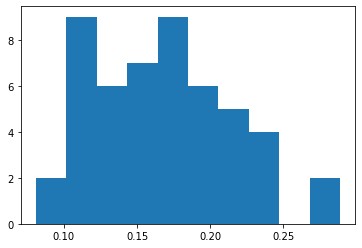

In [33]:
plt.hist(std_bus)

In [46]:
### get a list of booleans (true/false) to filter out scores that aren't high variance
boolean = std_bus > np.mean(std_bus) 

In [49]:
from itertools import compress
np.mean(list(compress(correlation_scores, boolean))) # filter out scores, and take the average
# THIS IS THE RESULT FOR HIGH VARIANCE

0.4977825882059288

# MISC

In [39]:
correlation_scores # get final scores

[0.22058823529411767,
 0.5177865612648221,
 0.06862745098039216,
 0.5211822660098521,
 0.3571428571428571,
 0.6377430061640588,
 0.010837438423645318,
 0.9285714285714288,
 0.03921568627450981,
 0.487012987012987,
 0.5090909090909091,
 0.6043956043956044,
 0.6606060606060605,
 0.4769230769230769,
 0.7714285714285712,
 0.4842105263157894,
 0.7411764705882353,
 0.6778640989167305,
 0.4088235294117647,
 0.5524475524475525,
 0.04761904761904763,
 0.6800825593395253,
 0.4761904761904762,
 0.41208791208791207,
 0.6090909090909091,
 0.4559386973180077,
 0.5637254901960785,
 0.2175438596491228,
 0.15384615384615385,
 0.6869230769230769,
 0.39999999999999997,
 -0.12967032967032965,
 0.49019607843137264,
 0.6166666666666666,
 0.26169786096256686,
 0.532967032967033,
 0.35664335664335667,
 0.2937755102040816,
 0.9333333333333332,
 0.6666666666666669,
 0.6573426573426573,
 0.6142857142857142,
 -0.03636363636363637,
 0.6223776223776225,
 0.5560439560439561,
 0.7500000000000002,
 0.39999999999999997

In [26]:
for stars in full_rankings.average_stars:
    print(np.std(stars))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [24]:
reviews_subset[1023]

"Vegas Fries - Bomb  \nWings - chewy & overcooked; not very flavorful \nBacon Mac n Cheese Burger - too much going on that I couldn't even taste the Mac n Cheese"

In [25]:
gen_sentiment(review, entities, parser = parser, sentiment_package='vader', rule=rule)

[('taste', -0.4939)]

In [29]:
correlation_scores

[0.22058823529411767,
 0.5177865612648221,
 0.06862745098039216,
 0.5211822660098521,
 0.3571428571428571,
 0.6377430061640588,
 0.010837438423645318,
 0.9285714285714288,
 0.03921568627450981,
 0.487012987012987,
 0.5090909090909091,
 0.6043956043956044,
 0.6606060606060605,
 0.4769230769230769,
 0.7714285714285712,
 0.4842105263157894,
 0.7411764705882353,
 0.6778640989167305,
 0.4088235294117647,
 0.5524475524475525,
 0.04761904761904763,
 0.6800825593395253,
 0.4761904761904762,
 0.41208791208791207,
 0.6090909090909091,
 0.4559386973180077,
 0.5637254901960785,
 0.2175438596491228,
 0.15384615384615385,
 0.6869230769230769,
 0.39999999999999997,
 -0.12967032967032965,
 0.49019607843137264,
 0.6166666666666666,
 0.26169786096256686,
 0.532967032967033,
 0.35664335664335667,
 0.2937755102040816,
 0.9333333333333332,
 0.6666666666666669,
 0.6573426573426573,
 0.6142857142857142,
 -0.03636363636363637,
 0.6223776223776225,
 0.5560439560439561,
 0.7500000000000002,
 0.39999999999999997

In [27]:
print("Final Correlation Score: ", np.mean(correlation_scores))

Final Correlation Score:  0.31726939016412703


In [30]:
x = [0.684,
0.145,
0.467,
0.392,
0.225,
-0.203,
0.2,
0.0198,
]

In [31]:
np.mean(x)

0.24122500000000002